In [2]:
import pandas as pd 

In [14]:
tenis_df = pd.read_csv("dane/Dane_ATP_2000-2024 d.csv", sep=';')


In [12]:
tenis_df.head(5)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1.0,NaN,...,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,...,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,...,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7.0,NaN,...,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,...,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0


In [15]:
columns_to_drop = [
    'tourney_id', 'tourney_name', 'draw_size', 'match_num', 'winner_seed',
    'winner_name', 'loser_seed', 'winner_ioc', 'loser_name', 'loser_seed',
    'loser_ioc', 'score'
]

tenis_df = tenis_df.drop(columns=columns_to_drop)
tenis_df.head(5)

,surface,tourney_level,tourney_date,winner_id,winner_entry,winner_hand,winner_ht,winner_age,loser_id,loser_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,Hard,A,20000110,103163,NaN,R,188.0,21.7,101543,NaN,...,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,Hard,A,20000110,102607,Q,R,190.0,24.5,102644,NaN,...,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,Hard,A,20000110,103252,NaN,R,175.0,21.3,102238,NaN,...,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,Hard,A,20000110,103507,NaN,R,183.0,19.9,103819,NaN,...,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,Hard,A,20000110,102103,Q,R,180.0,27.3,102765,NaN,...,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0


In [21]:
tenis_df['surface'].isnull().sum()

53

In [22]:
import matplotlib as plt

<Axes: ylabel='count'>

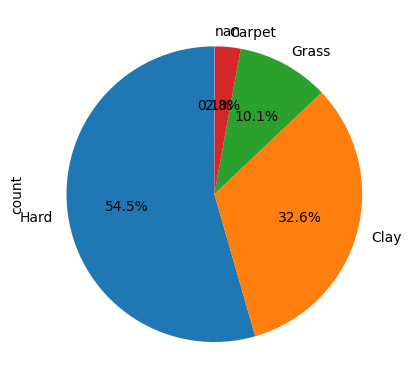

In [30]:
surface = tenis_df['surface'].value_counts(dropna=False)
surface.plot(kind='pie', autopct='%1.1f%%', startangle=90)
